In [1]:
# Importing modules
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import math
import matplotlib.pyplot as plt

In [2]:
# Data dir
data_dir = "./train"

# Transformation
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# Datasets
dataset = datasets.ImageFolder(data_dir, transform)

# Dataloader
dataloader = DataLoader(dataset, batch_size=32)

# Device
device = torch.device("cpu")

In [3]:
# Model architecture
class simpleNet(nn.Module):
    
    def __init__(self, n_classes = len(dataset.classes)):
                 super(simpleNet, self).__init__()
                 self.fc1 = nn.Linear(3*64*64, 1024)
                 self.fc2 = nn.Linear(1024, 128)
                 self.fc3 = nn.Linear(128, n_classes)
                 
    def forward(self, x):
                 x = torch.flatten(x, 1)
                 x = self.fc1(x)
                 x = torch.relu(x)
                 x = self.fc2(x)
                 x = torch.relu(x)
                 x = self.fc3(x)
                 return x

In [4]:
# Model
model = simpleNet()
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters())

In [5]:
# Print model
model

simpleNet(
  (fc1): Linear(in_features=12288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [6]:
# Number of epoch
n_epoch = len(dataloader)

# Initial learning rate 
i_lr = 1e-8

# Final learning rate
f_lr = 10.0

# Optimizer's learning rate
optimizer.param_groups[0]["lr"] = i_lr

# Step size for optimizer's learning rate
update_step = (f_lr / i_lr) ** (1 / n_epoch)

# Best loss
best_loss = float('inf')

# Best learning rate
best_lr = i_lr

# Log for losses
log_loss = []

# Log for learning rate
log_lr = []

# Batch No
batch_no = 1

# Loop for finding learning rate
for batch in dataloader:
    X, y = batch
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_hat = model(X)
    loss = criterion(y_hat, y)
    # Handling loss explosion
    if batch_no > 1 and loss > 4 * best_loss:
        break
    # If loss is < best loss
    elif loss < best_loss or batch_no == 1:
        best_loss = loss
        best_lr = optimizer.param_groups[0]["lr"]
    log_loss.append(loss.item())
    log_lr.append(optimizer.param_groups[0]["lr"])
    loss.backward()
    optimizer.step()
    # Update optimizer's learning rate
    optimizer.param_groups[0]["lr"] *= update_step
    # Update batch no
    batch_no += 1

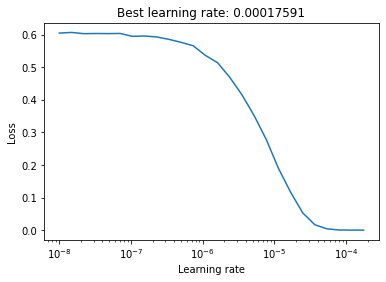

In [7]:
# Plot loss vs learning rate curve
plt.plot(log_lr, log_loss)
plt.xscale("log")
plt.title(f"Best learning rate: {round(best_lr, 8)}")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()